**Procesiranje podatkov**

V tej beležnici preberemo in shranimo podatke iz podatkovne zbirke slovenskih člankov ter jih pred-procesiramo.

# Priprava okolja

In [ ]:
!pip install stanza

     |████████████████████████████████| 342 kB 5.1 MB/s 


In [192]:
import zipfile
import tarfile
import json
import os

import stanza
stanza.download('sl')

from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')
from utils import read_json_file, save_articles, prepare_dataframe, visualize_articles_by_media, read_preprocessed_specific_media, dataframe_info
import pandas as pd




import seaborn as sns
from matplotlib import pyplot as plt
from collections import OrderedDict, defaultdict

2021-08-19 10:10:23 INFO: Downloading default packages for language: sl (Slovenian)...
2021-08-19 10:10:24 INFO: File exists: /root/stanza_resources/sl/default.zip.
2021-08-19 10:10:26 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pomožne funkcije

In [ ]:
def save_extracted_articles(articles, dir):
  """
  Save articles to a file.
  :param articles: articles to be saved
  """

  for media in articles.keys():
    filename = dir + media
    with open(filename, 'w', encoding='utf8') as fp:
      json.dump(articles[media], fp)

In [ ]:
def read_data_json(json_file, articles_by_media):
  """
  This function reads a single json file and it returns a dictionary of articles
  in json_file

  :param json_file: json file
  :param articles_by_media: a dictionary of media names as keys and articles as
  values
  :return: articles_by_media (new articles added)
  """

  data = json.load(json_file)

  articles_full = data['articles']['results']       # a dictionary (JSON) of all articles' metadata

  for article in articles_full:
    body = article['body']
    media = article['source']['title']
    title = article['title']
    
    if media not in articles_by_media.keys():
      articles_by_media[media] = {}
      articles_by_media[media]['body'] = []
      articles_by_media[media]['title'] = []

    articles_by_media[media]['body'].append(body)
    articles_by_media[media]['title'].append(title)

  return articles_by_media  

In [ ]:
def read_data_zip(filepath):

  """
  Read and save data from a zip file of dataset of Slovenian articles. A zip file contains 7 tar.gz 
  files, each one for a year from 2014 and 2020.

  :param filepath: path to the data zip file
  """

  with zipfile.ZipFile(filepath, 'r') as zip_file:

    year = 2014
    for year_file in zip_file.namelist()[1:8]:  
      save_path = f'/content/drive/MyDrive/Colab Notebooks/raw_articles/{year}/'

      articles_by_media = {}
      
      zip_file.extract(year_file)
      tar = tarfile.open(year_file)

      for member in tar.getmembers()[1:]:
        json_file = tar.extractfile(member.name)
        articles_by_media = read_data_json(json_file, articles_by_media)
        break

      try:
        save_extracted_articles(articles_by_media, save_path)
      except FileNotFoundError as err:
        print(err)
      break
      year += 1  

In [ ]:
def preprocess_articles(articles, stop_words, nlp):
  """
  Preprocess a list of raw articles. Remove words in stop_words list and are 
  shorter than 4 words from each article from article list and lemmatize each 
  word with nlp pipeline.

  :param articles: list of strings to preprocess
  :param stop_words: list of words to be removed from articles
  :param nlp: stanza pipeline for word lemmatization

  :return preprocessed_articles: a list of preprocessed articles (lists of lemmas)
  """

  preprocessed_articles = []    # list of preprocessed articles

  for article in articles:
    
    preprocessed_body = []     # a list of words of a single article
    for token in simple_preprocess(article, min_len=4, max_len=25):
      # remove all words shorter than three characters
      if token not in stop_words:
        preprocessed_body.append(token)

    doc = nlp(' '.join(preprocessed_body))
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words]

    preprocessed_articles.append(lemmas)

  return preprocessed_articles



In [124]:
def preprocess_media_articles(media_list, load_dir, save_dir):
  """
  Preprocess articles from media_list files in load_dir and save them to save_dir

  :param media_list: a list of media names we want to preprocess
  :param load_dir: a path to directory of files with raw articles
  :param save_dir: a path to directory where preprocessed files will be saved
  """

  stop_words = stopwords.words('slovene')
  new_sw = ["href", "http", "https", "quot", "nbsp", "mailto", "mail", "getty", "foto", "images", "urbanec", "sportid"]
  stop_words.extend(new_sw)

  filepath = '/content/drive/MyDrive/Colab Notebooks/stopwords'
  with open(filepath, 'r') as f:
    additional_stopwords = f.read().splitlines()

  stop_words.extend(additional_stopwords)
  stop_words = list(set(stop_words))

  config = {
  	'processors': 'tokenize, lemma', # Comma-separated list of processors to use
  	'lang': 'sl', # Language code for the language to build the Pipeline in
    'tokenize_pretokenized': True, # Use pretokenized text as input and disable tokenization
    'use_gpu': True
  }
  nlp = stanza.Pipeline(**config)

  
  for file in os.listdir(load_dir):

    if file not in media_list:
      continue

    save_filepath = save_dir + file
    if os.path.exists(save_filepath):
      print("File ", file, " already exists")
      continue

    if not os.path.exists(save_dir):
      os.mkdir(save_dir)

    load_filepath = load_dir + file
    articles = read_json_file(load_filepath)

    df = pd.DataFrame.from_dict(articles)
    df['word_length'] = df.body.apply(lambda x: len(str(x).split()))
    df = df.loc[df['word_length'] > 25]
    df = df.drop_duplicates(subset='title', keep="last")
    df = df.drop('word_length', axis=1)
    articles = df.to_dict('list')

    
    print(f"Preprocessing file: {file} with {len(articles['body'])} articles")
    preprocessed_articles = preprocess_articles(articles['body'], stop_words, nlp)
    
    save_articles(preprocessed_articles, save_filepath)
    print(f"File saved to {save_filepath}!\n**********************")

# Main

Nastavljanje konstant

In [199]:
YEAR = 2020
media_list = ['Slovenska tiskovna agencija STA', 'Siol.net Novice', '24ur.com', 'MMC RTV Slovenija', 'Dnevnik', 'Nova24TV', 'Svet24', 'Tednik Demokracija', 'PortalPolitikis']
load_dir = f'/content/drive/MyDrive/Colab Notebooks/raw_articles/{YEAR}/'
save_dir = f'/content/drive/MyDrive/Colab Notebooks/preprocessed_articles/{YEAR}/'

## **Predprocesiranje člankov**

V tem delu se prebere članke navedenih medijev v media_list, odstrani tiste s krajšim besedilom od 25 besed in tiste, ki imajo znotraj posameznega medija enake naslove (duplikati).

Nato vsak članek razdeli na besede (angl. tokenize), odstrani vse besede, ki so v stop_words (besede, ki nimajo nekega pomena, npr. da, tako, in...) in ki so krajše od 4 črk. Besede, ki so ostale lematiziramo (spremenimo v osnovno obliko)



In [123]:
preprocess_media_articles(media_list, load_dir, save_dir)

2021-08-19 09:13:05 INFO: Loading these models for language: sl (Slovenian):
| Processor | Package |
-----------------------
| tokenize  | ssj     |
| lemma     | ssj     |

2021-08-19 09:13:05 INFO: Use device: cpu
2021-08-19 09:13:05 INFO: Loading: tokenize
2021-08-19 09:13:05 INFO: Loading: lemma
2021-08-19 09:13:05 INFO: Done loading processors!


Preprocessing file: Nova24TV with 6277 articles
[['ilegalen', 'migrant', 'blokiraj', 'mejen', 'prehod', 'maljevac', 'kladuš', 'začeti', 'izsiljevati', 'gladovna', 'stavek', 'poročati', 'portal', 'krupljana', 'mejen', 'prehod', 'zaprt', 'ilegalen', 'migrant', 'oviraja', 'dostop', 'jejen', 'policija', 'odpreti', 'prehod', 'migrant', 'preselija', 'kladuša', 'center', 'bosen', 'hercegovina', 'odpreti', 'nov', 'center', 'ušivak', 'poročati', 'radio', 'sarajev', 'skupina', 'podjetnik', 'napovedati', 'protest', 'zaprt', 'mejni', 'prehod', 'delo', 'gospodarski', 'škoda', 'poročati', 'portal', 'biščan', 'ilegalen', 'migrant', 'vztrajati', 'naprej', 'zahtevati', 'odprejo', 'mejen', 'prehod', 'spustiti', 'hrvaški', 'doseči', 'skupina', 'ilegalec', 'začeti', 'gladovna', 'stavek', 'strokovnjak', 'praviti', 'človek', 'gladovna', 'stavka', 'zdrž', 'pomeniti', 'umr', 'hitro', 'zato', 'imeti', 'oblast', 'čas', 'prepričaja', 'prenehati', 'početje', 'odziv', 'telo', 'človek', 'gladovna', 'stavka', 'čas',

**Post-procesiranje**

Pri določenih medijih se določeni deli člankov pojavljajo v mnogih člankih, zato je smiselno te ponavljajoče se dele odstraniti vsaj iz že pred-procesiranih člankov.

*Slovenska tiskovna agencija STA:* Vsak članek se začne na način: 'Ljubljana, 29. oktobra (STA)' - 'vsebina članka'. Te dele torej odstranimo.

*24ur.com*: Veliko člankov ima na začetku članka del besedila, ki se nanaša na omogočanje piškotkov spletnega mesta. Ta del odstranimo iz člankov.

*Siol.net Novice*: Veliko člankov se začne z besedilom, ki se nanaša ta t.i. *termometer*, ki bralcu razloži vlogo le-tega pri poročanju o popularnosti članka. Tudi te dele odstranimo iz člankov.


Poleg tega odstranimo tudi članke z manj kot 25 besedami.

In [184]:
df = prepare_dataframe(media_list, YEAR)

Slovenska tiskovna agencija STA
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


Siol.net Novice
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


24ur.com
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


MMC RTV Slovenija
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


Nova24TV
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


Svet24
First short articles...
First duplicates...
Tednik Demokracija
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


PortalPolitikis
First short articles...


/content/drive/MyDrive/Colab Notebooks/utils.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preprocessed_body'] = read_preprocessed_specific_media([media], year)


In [ ]:
# ZA STA PREDPROCESIRANE BODY-JE

print(df.loc[df.media == 'Slovenska tiskovna agencija STA', 'preprocessed_body'])
# df.loc[df.media == 'Slovenska tiskovna agencija STA', 'preprocessed_body'] = df.loc[df.media == 'Slovenska tiskovna agencija STA', 'preprocessed_body'].apply(lambda x: x[1:])

# Če izhod naslednje vrstice na začetku vsakega seznama ne vsebuje več imena kraja ali meseca, smo odstranili ponavljajoče se dele
print(df.loc[df.media == 'Slovenska tiskovna agencija STA', 'preprocessed_body'])

# # ZA Siol PREDPROCESIRANE BODY-JE
# df.loc[df.media == 'Siol.net Novice', 'preprocessed_body'] = df.loc[df.media == 'Siol.net Novice', 'preprocessed_body'].apply(lambda x: x[10:] if x[0] == 'termometer' else x)

# Če je izhod naslednje vrstice enak '['ne']', potem smo odstranili ponavljajoče se dele besedila
print(df.loc[df.media == 'Siol.net Novice', 'preprocessed_body'].apply(lambda x: 'ja' if x[0] == 'termometer' else 'ne').unique())

# # ZA 24ur.com PREDPROCESIRANE BODY-JE
# df.loc[df.media == '24ur.com', 'preprocessed_body'] = df.loc[df.media == '24ur.com', 'preprocessed_body'].apply(lambda x: x[10:] if 'piškotek' in x[:9] else x)

# Če je izhod naslednje vrstice enak '['ne']', potem smo odstranili ponavljajoče se dele besedila
print(df.loc[df.media == '24ur.com', 'preprocessed_body'].apply(lambda x: 'ja' if 'piškotek' in x[:9] else 'ne').unique())


# save_preprocessed_articles(df.loc[df.media == 'Slovenska tiskovna agencija STA', 'preprocessed_body'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/preprocessed_articles/'+ str(2017) + '/' + 'Slovenska tiskovna agencija STA')
# save_preprocessed_articles(df.loc[df.media == 'Siol.net Novice', 'preprocessed_body'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/preprocessed_articles/'+ str(YEAR) + '/' + 'Siol.net Novice')
# save_preprocessed_articles(df.loc[df.media == '24ur.com', 'preprocessed_body'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/preprocessed_articles/'+ str(YEAR) + '/' + '24ur.com')

0        [disciplinski, komisijati, evropski, nogometen...
1        [aires, portret, dieg, armand, maradone, rojen...
2        [napoved, dogodkov, slovenji, mednaroden, deja...
3        [nogometaš, maribori, lig, telek, slovenij, go...
4        [nadzornik, čel, karmen, dietner, današnji, se...
                               ...                        
69159    [nov, litovski, vlad, napovedati, uvedbo, stro...
69160    [zdravstven, zaščit, milijarde, ljud, svet, od...
69161    [žirovski, alpin, pandemij, covid, dolgotrajen...
69162    [japonski, razpoloženje, predelovalen, sektorj...
69163    [let, starost, konec, teden, posledica, pljučn...
Name: preprocessed_body, Length: 69164, dtype: object
0        [disciplinski, komisijati, evropski, nogometen...
1        [aires, portret, dieg, armand, maradone, rojen...
2        [napoved, dogodkov, slovenji, mednaroden, deja...
3        [nogometaš, maribori, lig, telek, slovenij, go...
4        [nadzornik, čel, karmen, dietner, današnji, se...
  

## **Predstavitev končnih podatkov**

Prikaz števila člankov posameznega leta v določenem letu.

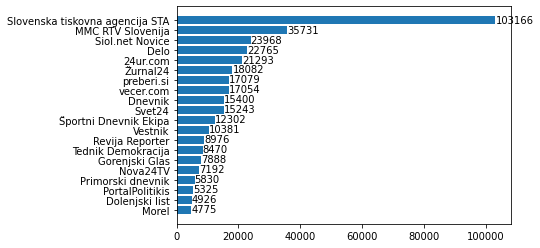

In [200]:
count = {}
for f in os.listdir(load_dir):
  if os.path.isfile(f'{load_dir}{f}'):
    articles = read_json_file(f'{load_dir}{f}')
    count[f] = len(articles['body'])

count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True)[:20])

visualize_articles_by_media(list(count.keys()), list(count.values()))

In [ ]:
df = prepare_dataframe(media_list, YEAR)

Prikaz števila člankov izbranih medijev v izbranem letu

Število vseh člankov skupaj: 163894


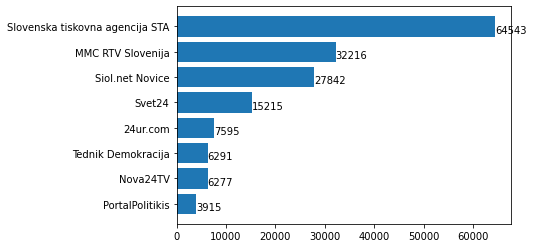

In [203]:
count_articles = df.media.value_counts().to_dict()
media_names = list(count_articles.keys())
counts = list(count_articles.values())
print(f'Število vseh člankov skupaj: {sum(counts)}')
visualize_articles_by_media(count_articles, counts)

Prikaz števila besed v člankih izbranih medijev (skupno)

         word_length
count  163894.000000
mean      246.452591
std       326.172821
min        26.000000
25%        46.000000
50%       146.000000
75%       329.000000
max      7503.000000


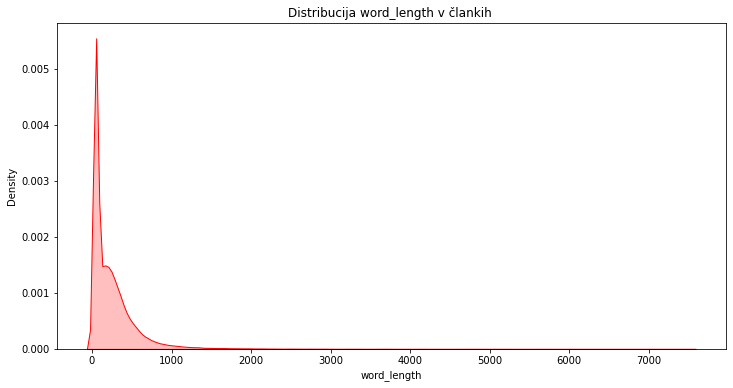

In [204]:
dataframe_info(df, 'word_length')

Prikaz števila besed v člankih izbranih medijev (vsak medij posebej)


Slovenska tiskovna agencija STA
        word_length
count  64543.000000
mean      45.340889
std        3.258329
min       26.000000
25%       43.000000
50%       45.000000
75%       47.000000
max       70.000000

Siol.net Novice
        word_length
count  27842.000000
mean     392.059622
std      381.139148
min       31.000000
25%      172.000000
50%      283.000000
75%      474.000000
max     7423.000000

24ur.com
       word_length
count  7595.000000
mean    257.812508
std     215.544018
min      47.000000
25%     139.000000
50%     203.000000
75%     308.500000
max    4175.000000

MMC RTV Slovenija
        word_length
count  32216.000000
mean     406.705767
std      390.089257
min       38.000000
25%      207.000000
50%      311.000000
75%      475.000000
max     7503.000000

Nova24TV
       word_length
count  6277.000000
mean    433.426956
std     398.075321
min      56.000000
25%     203.000000
50%     320.000000
75%     546.000000
max    5374.000000

Svet24
        word_length
c

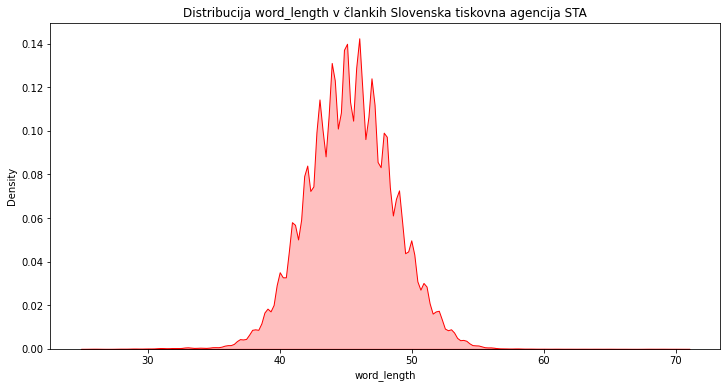

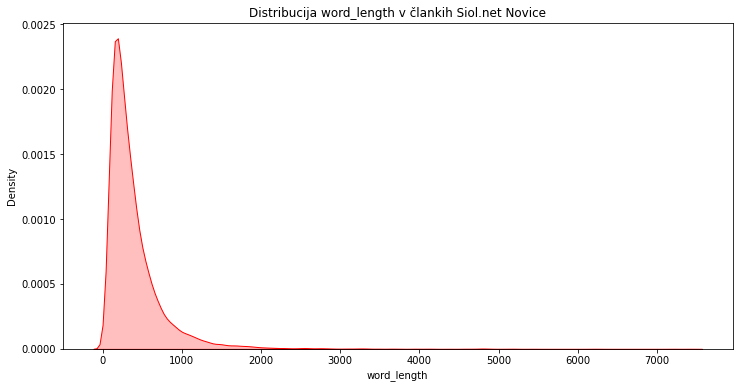

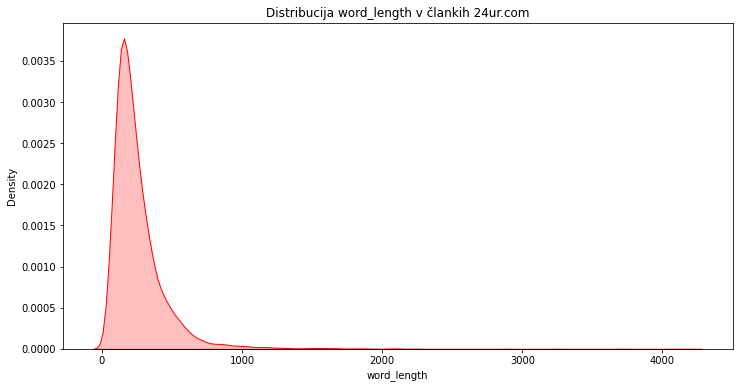

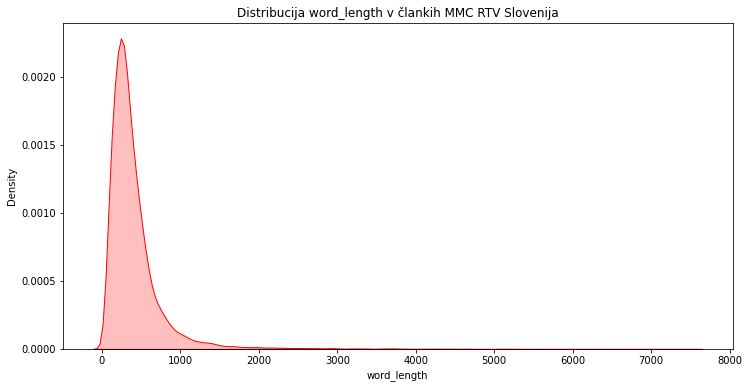

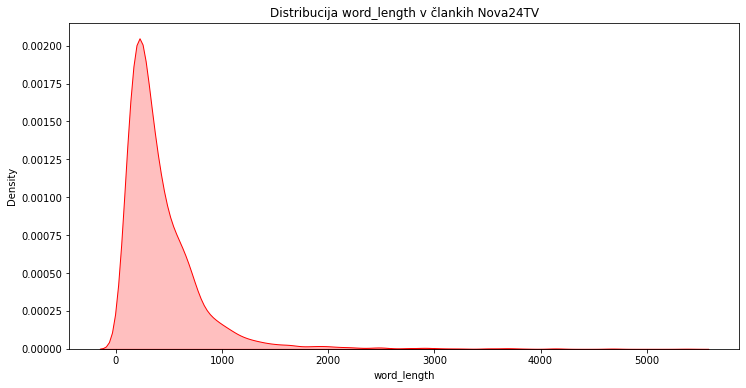

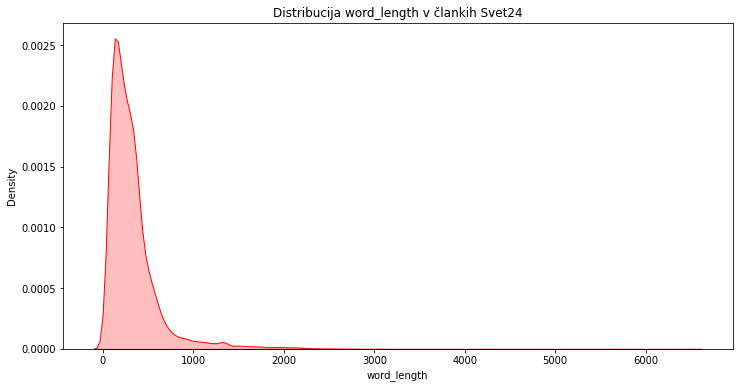

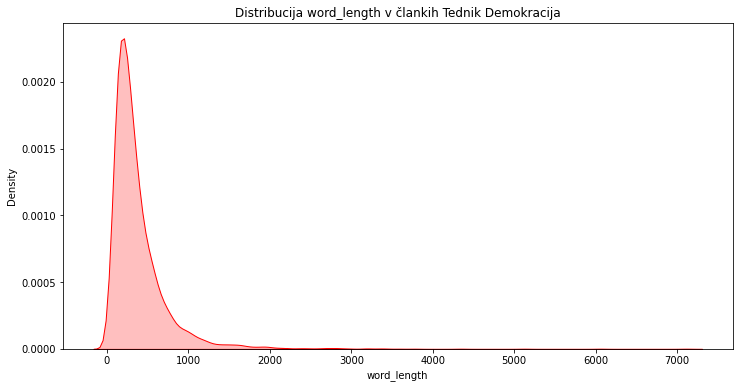

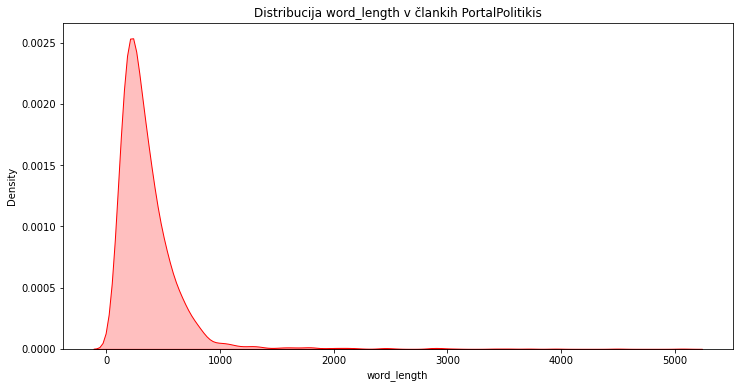

In [205]:
for media in media_list:
  print(f'\n{media}')
  dataframe_info(df.loc[df.media == media], 'word_length', media)